In [77]:
%reload_ext autoreload
%autoreload 2

In [331]:
# %load "/Users/haleighwright/Desktop/NCEAS/pyriv/notebooks/nb_config.py"
import sys
sys.path.append("/Users/haleighwright/Desktop/NCEAS/pyriv")
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")
import networkx as nx
import numpy as np
import sys
import geopandas as gpd
import seaborn # makes matplotlib graphs look prettier
from shapely.geometry import Point
from multiprocessing import Pool

from pyriv import graph_prep as GraphBuilder
from pyriv import river_graph as RiverGraph
from pyriv import snapping_processor as SnapTool

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # makes matplotlib graphs 2x resolution for retina display

from pyriv import snapping_processor as SnapTool

In [222]:
# read in NON-PRUNED high-res AK map
ak_full = GraphBuilder.GraphBuilder('../../Data/sasap/NatMapCoastline3338/NatMapGDF/NatMapGDF.shp')

Weighting Edges with Distances


In [223]:
print(len(ak_full.graph.nodes()))
print(len(ak_full.graph.edges()))

418120
415940


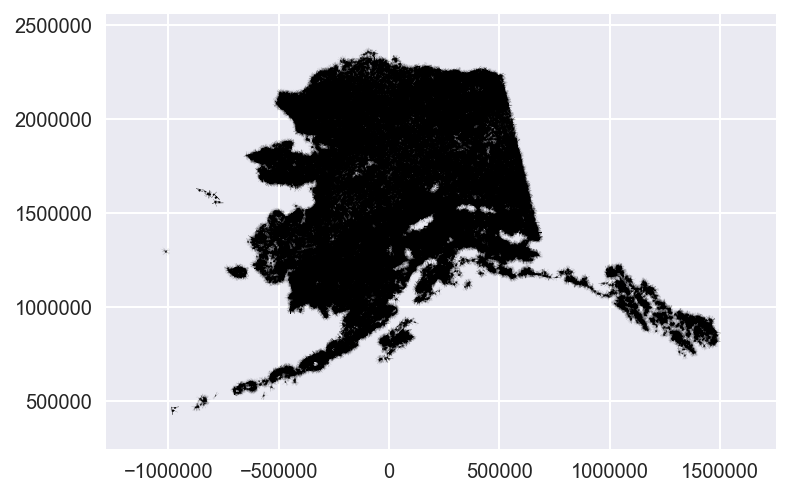

In [224]:
ak_full.graph.plot()

### decide which nodes we want to check between (we dont want to check whole state)

In [143]:
#read in the higher-res SASAP subset of canada
ca_sasap_graph = GraphBuilder.GraphBuilder('../../Data/canada/SASAP_CA_DrainlinesSO2/SASAP_Canada_DrainlinesSO2.shp')

Weighting Edges with Distances


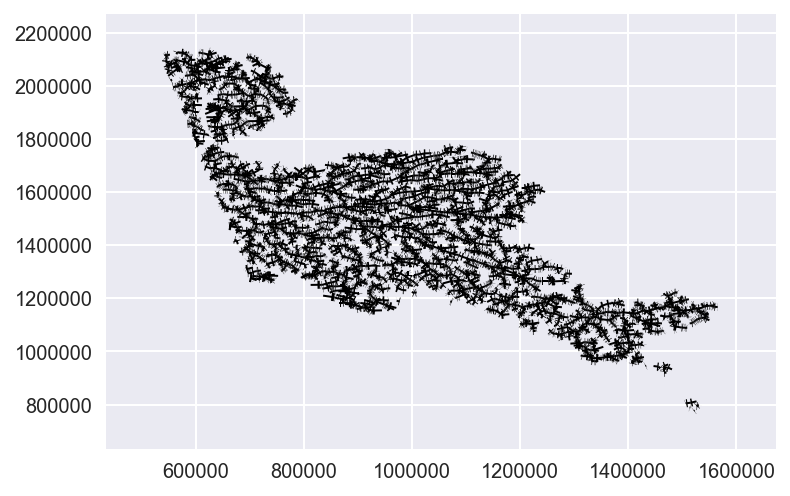

In [153]:
ca_sasap_graph.graph.plot()

In [116]:
AK_border_graph = GraphBuilder.GraphBuilder('../../Data/sasap/NatMapCoastline3338/AK_border_nodes.shp')

Weighting Edges with Distances


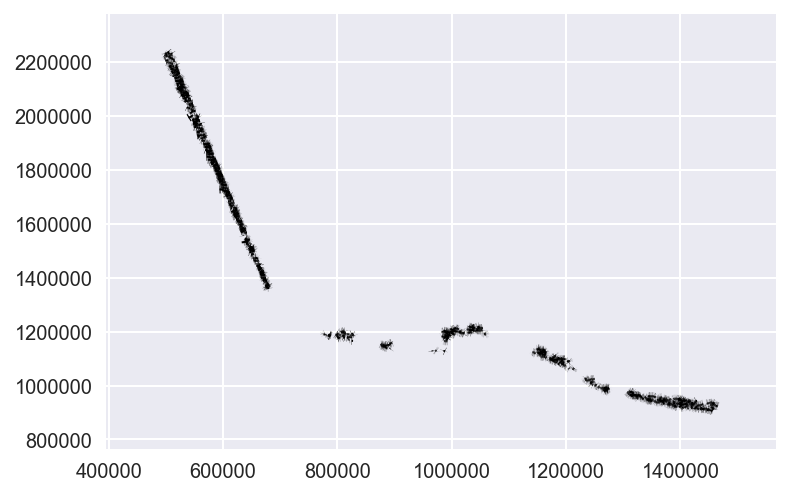

In [157]:
AK_border_graph.graph.plot()

In [119]:
#collect all nodes that match border nodes from the main AK graph into a list
all_ak_nodes = orig_ak_pruned.nodes()

In [123]:
border_ak_nodes = AK_border_graph.graph.nodes()

#### find subsetted bordering nodes in the larger AK graph and get ahold of them for snapping

In [226]:
%%time
#thresh = 0.000000001
border_subset_complete = []
for node in ak_full.graph.nodes():
    for bordernode in border_ak_nodes:
        if node == bordernode :
            border_subset_complete.append(node)
            break


CPU times: user 5min 54s, sys: 4.06 s, total: 5min 58s
Wall time: 6min 6s


In [227]:
print len(border_subset_complete)
print len(border_ak_nodes) #populated by equality, not threshold 


5124
5124


In [173]:
def pts_to_shp(pts, outpath):
    pts = list(pts)
    kcdf = gpd.GeoDataFrame({'geometry': [Point(n) for n in pts]})
    kcdf.crs = {'init': 'epsg:3338'}
    kcdf.to_file(outpath)

In [155]:
# assumptions: only one connection is to be added by snapping (larger thresholds could create 
#              extraneous edges and connections); here we are only concerned with snapping AK to CA, nothing else

ca_deadends = ca_sasap_graph.graph.deadends()
ak_border_deadends = AK_border_graph.graph.deadends()

In [166]:
rev_AK_border_graph = AK_border_graph.graph.reverse()

In [180]:
rev_ca_sasap_graph = ca_sasap_graph.graph.reverse()
rev_ca_deadends = rev_ca_sasap_graph.deadends()
pts_to_shp(rev_ca_deadends, '../../data/canada/SASAP_CA_DrainlinesSO2/rev_ca_deadends.shp')

In [181]:
print len(ca_deadends)
print len(ak_border_deadends)
print len(rev_ak_border_deadends)
print len(rev_ca_deadends)

41
189
360
1293


#### have to join network 2 ways: AK --> CA and AK <-- CA 

In [213]:
%%time
missing_edges_ak_ca = join_two_disjoint_river_networks(ak_border_deadends, rev_ca_deadends, 13000.0, 2)

213.680246977
CPU times: user 513 ms, sys: 147 ms, total: 660 ms
Wall time: 557 ms


In [214]:
print len(missing_edges_ak_ca)

34


In [212]:
def join_two_disjoint_river_networks(graph1, graph2, dist_thresh, direction):
    # we only want to add links *B/W* the 2 graphs in this case
    #outeriter = 0
    mindist = np.inf
    edges_to_add = []
    for end1 in graph1:
        for end2 in graph2:
            xd = end1[0] - end2[0]
            yd = end1[1] - end2[1]
            dist = np.sqrt((xd*xd + yd*yd))
            if dist < mindist:
                mindist=dist
            #print dist
            if dist < dist_thresh and dist > 0:
                if direction == 1: # flow *from* 2 *into* 1
                    edges_to_add.append((end2, end1, {'distance':dist}))
                    break # we only want to connect one edge per node
                elif direction == 2: # flow *from* 1 *into* 2
                    edges_to_add.append((end1, end2, {'distance':dist}))
                    break # we only want to connect one edge per node
            #outeriter = outeriter + 1  
    print mindist
    return edges_to_add

In [229]:
ak_and_ca = nx.compose(ak_full.graph, ca_sasap_graph.graph)

In [230]:
# this is the original from which to make copies
ak_and_ca_1 = ak_and_ca.copy()

In [231]:
ak_and_ca.add_edges_from(missing_edges_ak_ca)

In [232]:
print len(ak_and_ca.edges())

421603


In [233]:
print len(ak_and_ca_1.edges())

421569


In [235]:
421603 - 421569


34

### awesome! looks like it worked. now check on qgis and do the reverse direction way...

In [236]:
nx.write_shp(ak_and_ca, '../../Data/sasap/NatMapCoastline3338/NatMapGDF/NatMapLinkAKtoCA.shp')

In [237]:
# make a copy of the graph with only AK --> CA links made [save just in case]
ak_and_ca_links1 = ak_and_ca.copy()

In [238]:
#rename some variables for clarity
ak_and_ca_dir1 = ak_and_ca
ak_and_ca_disjoint = ak_and_ca_1


In [239]:
missing_edges_ca_ak = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 13000.0, 2)

1748.04277816


In [250]:
%%time
missing_edges_ca_ak_9 = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 9000.0,2)

len(missing_edges_ca_ak_9)

352.394170726
CPU times: user 26.3 ms, sys: 8.52 ms, total: 34.9 ms
Wall time: 32.5 ms


In [251]:
missing_edges_ca_ak_8 = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 8000.0,2)
len(missing_edges_ca_ak_8)

352.394170726


20

In [252]:
missing_edges_ca_ak_6 = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 6000.0,2)
len(missing_edges_ca_ak_6)

352.394170726


20

In [253]:
missing_edges_ca_ak_3 = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 3000.0,2)
len(missing_edges_ca_ak_3)

352.394170726


15

In [254]:
missing_edges_ca_ak_4 = join_two_disjoint_river_networks(ca_deadends, rev_ak_border_deadends, 4000.0,2)
len(missing_edges_ca_ak_4)

352.394170726


17

In [240]:
len(missing_edges_ca_ak)

26

In [243]:
ak_and_ca.add_edges_from(missing_edges_ca_ak)

In [244]:
len(ak_and_ca.edges())

421629

In [246]:
421629-421603

26

## works! now we're all linked up. save it out.

In [247]:
nx.write_shp(ak_and_ca, '../../Data/sasap/NatMapCoastline3338/NatMapGDF/AK_CA_highres_snapped.shp')

## need to choose the node with the lowest distance, not just the first one over threshold. modify method to do so...

In [273]:
def join_two_disjoint_river_networks_min(graph1, graph2, dist_thresh, direction):
    # we only want to add links *B/W* the 2 graphs in this case
    #outeriter = 0
    mindist = np.inf
    edges_to_add = []
    potential_edges = {}
    for end1 in graph1:
        for end2 in graph2:
            xd = end1[0] - end2[0]
            yd = end1[1] - end2[1]
            dist = np.sqrt((xd*xd + yd*yd))
            if dist < dist_thresh and dist > 0:
                if direction == 1: # flow *from* 2 *into* 1
                    if end2 not in potential_edges or potential_edges[end2][2]['distance'] > dist:
                            potential_edges[end2] = (end2, end1, {'distance':dist})
                    #edges_to_add.append((end2, end1, {'distance':dist}))
                    #break # we only want to connect one edge per node
                elif direction == 2: # flow *from* 1 *into* 2
                    if end1 not in potential_edges or potential_edges[end1][2]['distance'] > dist:
                        potential_edges[end1] = (end1, end2, {'distance':dist})
                    
                    #edges_to_add.append((end1, end2, {'distance':dist}))
                    #break # we only want to connect one edge per node
            #outeriter = outeriter + 1  
    
    edges_to_add = [ v for v in potential_edges. values() ]
    return edges_to_add

In [274]:
missing_edges_ca_ak_6_m = join_two_disjoint_river_networks_min(ca_deadends, rev_ak_border_deadends, 6000.0,2)
len(missing_edges_ca_ak_4)

20

In [283]:
temp = []
for val in missing_edges_ca_ak_6_m:
     temp.append(val[2]['distance'])
print sorted(temp)

[352.3941707255247, 385.61699073550079, 479.55835877617483, 553.47138759099596, 1143.0222590880078, 1526.0120934478045, 1580.5694052547974, 1654.1075252629958, 1748.0427781626408, 2029.5133061343308, 2077.5350082600639, 2183.5216235325233, 2753.679659069247, 2797.8355448496068, 2920.2094203401225, 3104.7196611800164, 3814.7275582118814, 4126.6694676899697, 4269.0429272648516, 5843.2135316088425]


In [303]:
def edge_distances(edge_list):
    temp = []
    for val in edge_list:
         temp.append(val[2]['distance'])
    return temp

In [284]:
temp = []
for val in missing_edges_ca_ak_6:
    temp.append(val[2]['distance'])
print sorted(temp)


[352.3941707255247, 385.61699073550079, 479.55835877617483, 1143.0222590880078, 1526.0120934478045, 1580.5694052547974, 1748.0427781626408, 2183.5216235325233, 2797.8355448496068, 2920.2094203401225, 3814.7275582118814, 4126.6694676899697, 4269.0429272648516, 4450.4305213292246, 5015.2837274091726, 5460.867813681416, 5589.7047865944132, 5701.8917358689714, 5782.3277850540644, 5843.2135316088425]


In [285]:
missing_edges_ak_ca_min = join_two_disjoint_river_networks_min(ak_border_deadends, rev_ca_deadends, 12000.0, 2)

In [287]:
print sorted(edge_distances(missing_edges_ak_ca_min))

[352.3941707255247, 385.61699073550079, 479.55835877617483, 553.47138759099596, 1143.0222590880078, 1526.0120934478045, 1580.5694052547974, 1654.1075252629958, 1748.0427781626408, 2029.5133061343308, 2077.5350082600639, 2183.5216235325233, 2753.679659069247, 2797.8355448496068, 2920.2094203401225, 3104.7196611800164, 3814.7275582118814, 4126.6694676899697, 4269.0429272648516, 5843.2135316088425]


In [288]:
print sorted(edge_distances(missing_edges_ak_ca))

[352.3941707255247, 385.61699073550079, 479.55835877617483, 553.47138759099596, 1143.0222590880078, 1526.0120934478045, 1580.5694052547974, 1654.1075252629958, 1748.0427781626408, 2029.5133061343308, 2077.5350082600639, 2183.5216235325233, 2753.679659069247, 2797.8355448496068, 2920.2094203401225, 3104.7196611800164, 3814.7275582118814, 4126.6694676899697, 4269.0429272648516, 5843.2135316088425]


In [289]:
 ak_and_ca_links1.add_edges_from(missing_edges_ca_ak_6_m)

In [290]:
nx.write_shp(ak_and_ca_links1, '../../Data/sasap/NatMapCoastline3338/NatMapGDF/AK_CA_highres_snapped_2.shp')

## Retry with new method that takes min dist, from scratch

In [311]:
ak_and_ca_composed = nx.compose(ak_full.graph, ca_sasap_graph.graph)

In [312]:
print len(ak_full.graph.edges())
print len(ca_sasap_graph.graph.edges())
print len(ak_and_ca_composed.edges())

415940
5629
421569


In [314]:
# keep a copy of the composed graph without any added edges
ak_ca_disjoint_FINAL = ak_and_ca_composed.copy()

In [315]:
missing_edges_ak_to_ca_8_m = join_two_disjoint_river_networks_min(ak_border_deadends, rev_ca_deadends, 8000.0, 2)

In [316]:
print(len(missing_edges_ak_to_ca_8_m))

21


In [318]:
print sorted(edge_distances(missing_edges_ak_to_ca_8_m))

[174.4884007793419, 213.68024697692732, 717.58362072005514, 889.89737788171317, 1609.3204070740926, 1636.6817004799382, 1759.7223831146878, 1999.2475555651515, 2106.7192490092666, 2324.3932587105846, 3890.3756249174512, 4821.4637509765398, 5108.1332476319676, 5508.1816704983758, 5672.388013788498, 5809.035514250435, 6241.2227200348707, 6708.2364412822517, 7077.1772469808575, 7440.0960783721557, 7990.3702145472853]


In [319]:
ak_and_ca_composed.add_edges_from(missing_edges_ak_to_ca_8_m)

In [320]:
missing_edges_ca_ak_6_m = join_two_disjoint_river_networks_min(ca_deadends, rev_ak_border_deadends, 6000.0,2)

In [332]:
GraphBuilder.write_shp(ak_and_ca_composed, '../../Data/sasap/NatMapCoastline3338/NatMapGDF/AK_CA_c2a_4.shp')

## why are the outputted edges not corresponding? need to check ^^^

In [292]:
ak_and_ca_2 = nx.compose(ak_full.graph, ca_sasap_graph.graph)

In [294]:
missing_edges_ak_to_ca_11_m = join_two_disjoint_river_networks_min(ak_border_deadends, rev_ca_deadends, 11000.0, 2)

In [305]:
print len(missing_edges_ak_to_ca_11_m)
print sorted(edge_distances(missing_edges_ak_to_ca_11_m))

26
[174.4884007793419, 213.68024697692732, 717.58362072005514, 889.89737788171317, 1609.3204070740926, 1636.6817004799382, 1759.7223831146878, 1999.2475555651515, 2106.7192490092666, 2324.3932587105846, 3890.3756249174512, 4821.4637509765398, 5108.1332476319676, 5508.1816704983758, 5672.388013788498, 5809.035514250435, 6241.2227200348707, 6708.2364412822517, 7077.1772469808575, 7440.0960783721557, 7990.3702145472853, 8333.6679064970394, 9053.0361123088733, 9601.3803619686678, 10274.98067118128, 10698.096052904908]


In [304]:
print len(missing_edges_ak_ca)
print sorted(edge_distances(missing_edges_ak_ca))

34
[213.68024697692732, 889.89737788171317, 1636.6817004799382, 1759.7223831146878, 1999.2475555651515, 2106.7192490092666, 2324.3932587105846, 3890.3756249174512, 4821.4637509765398, 5108.1332476319676, 5508.1816704983758, 5809.035514250435, 6241.2227200348707, 6708.2364412822517, 7077.1772469808575, 7440.0960783721557, 8052.3786073605761, 8333.6679064970394, 8741.082348715121, 9053.0361123088733, 9601.3803619686678, 11126.083706354406, 11279.569619384729, 11375.191871829093, 11966.587037290943, 12175.454479984295, 12304.905107760802, 12333.809734790724, 12360.684867169874, 12366.906686486047, 12397.617267217462, 12479.715208444088, 12723.153382524964, 12747.84412639985]


In [306]:
ak_and_ca_2.add_edges_from(missing_edges_ak_to_ca_11_m)

In [307]:
ak_and_ca_2.add_edges_from(missing_edges_ca_ak_6_m)

In [308]:
nx.write_shp(ak_and_ca_links1, '../../Data/sasap/NatMapCoastline3338/NatMapGDF/AK_CA_highres_snapped_3.shp')

In [309]:
missing_edges_ak_to_ca_8_m = join_two_disjoint_river_networks_min(ak_border_deadends, rev_ca_deadends, 8000.0, 2)

In [310]:
print len(missing_edges_ak_to_ca_8_m)

21
